# $\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
$



# Temporal Difference Learning

<br/>
<br/><br/><br/>

### ITCS 4156

### Instructor: Minwoo "Jake" Lee

# Goal

The goal of this activity explore temporal difference learning via our control theories of on-policy SARSA and off-policy Q-learning for the discrete marble task. Instead of solving the MDP directly, as we did last week, we'll try to learn the values of the states using temporal difference (TD). Follow the TODO titles and comments to finish the activity! 

# Agenda

1. Review Discrete Marble Task and Class
2. Review Temporal Difference (TD)
3. SARSA
4. Q-Learning

In [1]:
# Common imports
import numpy as np
from copy import deepcopy as copy

# To plot pretty figures
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import IPython.display as ipd  # for display and clear_output
from IPython.core.debugger import set_trace

# print only 3 digits under decimal point
np.set_printoptions(precision=3, suppress=True)

# Review Discrete Marble Task 

The discrete marble task is actually a rather simple task. The goal of this task is to move a marble from any given location on a 1-D line to the goal location. The marble is restricted to discrete actions of move left, right, or don't move (no action).

## Environment and Actions
For this task our environment is defined by a marble on a 1-D line. This "1-D line" also defines our possibles actions as the following: move left, move right, or don't move (no action). Each action is defined as a discrete number: -1 (left), 0 (don't move), or 1 (right). These discrete numbers also determine the distance the marble moves on the 1-D line. This means each state must be defined by an integer! In our case, our state representations will range between 0 and 10 (see below image). At some point on the 1-D line there is also a goal state. Thus, the goal of the task is to explore the environment to find the goal state.

If you're still confused on the environment setup see the picture below. Here you can see the marble in red with its 3 possible actions. Each move left or right actions moves the marble 1 unit (left or right) on the 1-D line. The goal state location is at 5 and the starting marble state location is at 3. Thus, the marble has to perform 2 move right actions to reach the goal state. 

<img src="https://i.imgur.com/MwXDZPI.png">



To start off, we must define the MDP before we can solve the discrete marble task. Let's define what our representations will be for the standard MDP model $(S, A, P, R, \gamma)$.


$S = [0, 10] $ defines the possible states of the marble

$A = [-1, 0, 1] $ defines the actions push left, none, or right

$P$ = 1 defines the deterministic transition probability

$R =
  \begin{cases}
   1  & \quad \text{if marble is in the goal state}\\
   0  & \quad \text{otherwise}
  \end{cases}.
$

# DMarble Environment Class

Let us reuse the DMarble class from last week. 

In [13]:
class DMarble(object):
    """ Reinforcement learning Model for Discrete Marble. 
    
        states: x, dx
        action: action [-1, 0, 1]

        |            ___                     |
        |___________|///|____G_______________|
                    <- ->    
    """

    def __init__(self, goal=5, **params):
        """  create an object with the given goal
        
            attributes
            ===========
            act_bound   list
                        the bounds for actions 
            bound       list
                        the bounds for states 
            goal        list
                        the goal location
        """
        self.act_bound = [-1, 1]
        self.bound = [0, 10]
        self.goal = goal

    def init(self, start=None):
        """ initialize the starting position
        
            paramters
            ----------
            start   int
                    the start position (optional). if not given, random
            @return current state
        
        """
        
        if start is None:
            cur_state =  np.random.randint(self.bound[0], self.bound[1]+1)
        else:
            cur_state = start
        return cur_state
       
   
    def next(self, s, a):
        """ simulate 1 step by taking the action from the given state 
            it updates the current states (_cur_state) and 
            flag variable if it ends the episode (_done)
        
            paramters
            ----------
            s       int
                    current state
            a       int
                    action 
            @return list of next state, reward, done
        """
        s1 = copy(s)  # copy the current state
        
        s1 += a   
        
        # check if it hits the ends 
        if s1 < self.bound[0]:
            s1 = self.bound[0]
        elif s1 > self.bound[1]:
            s1 = self.bound[1] 
        r1 = self._get_reward(s1)
        
        return s1, r1
    
    ###### getters #############################
    
    ### reward function 
    def _get_reward(self, s1):
        return 1 if s1 == self.goal else 0
    
    ### function to check the end condition
    def is_done(self, s):
        return s == self.goal

    ### get all the possible actions
    def get_actions(self):
        # return all the possible actions in a list
        return [-1, 0, 1]
    
    ### get a random action
    def get_random_action(self):
        # return randomly selected action 
        return np.random.choice(self.get_actions())
    
    ### get the number of states
    def get_n_states(self):
        return self.bound[1] - self.bound[0] + 1
    
    ### get the number of actions
    def get_n_actions(self):
        return len(self.get_actions())

# Review Temporal Difference (TD)
Let's quickly recall our temporal difference (TD) algorithm as SARSA and Q-learning are derivatives of TD.

## Algorithm Summary
Below is the TD algorithm. Let's quickly break down what is happening.
$$
    V(s_t) \leftarrow V(s_t) + \alpha ( R_{t+1} + \gamma V(s_{t+1}) - V(s_t)). 
$$

### Notation
- **state-value** or **V-value**
    -  $V(s)$ 
    - The estimated value of a state given said state $s$

Recall that $V(s_t)$ is the state-value estimation of our current state $s$ at a given step $t$. Next, recall that $V(s_{t+1})$ is the state-value estimation of our next state $s$ at step $t+1$. Lastly, our reward for entering the next state is given by $R_{t+1}$. We also have $\gamma$ our discount factor for discounting states and $\alpha$ our learning rate for gradient updates.

Whenever you see the notation $V(s)$ you should immediately realize that we are working with a state-value function equation. That is, we are only assessing the value of a state based the state information $s$. If you're uncertain what this means, think of the tabular case. Let's say we have a table that stores our state-value estimations called a V-table. Then our V-table is a vector whose length is the same as the number of states in our task. For example, the marble problem has 11 states, 0 to 10. Thus, our V-table has a length of 11. So, for now, you can think about $V(s)$ as $V[s]$, where $s$ is indexing our V-table to get the current V-value (state-value estimation) for state $s$.

### What is happening
At each step $t$ we are running the above equation to update the current state's V-value $V(s_t)$. In order to do so though we need a target to assess the value of our current state. Much like any machine learning problem a target is need for the loss function to guide our learning (i.e. gradient updates). 

Our target comes in the form of the estimated value of the next state's V-value $ R_{t+1} + \gamma V(s_{t+1})$. This means we have to wait one step in order to update our current V-value $V(s_t)$. Thus, the meat of the TD equation is computing the difference between the next state's V-value (target) and our current state's V-value $( R_{t+1} + \gamma V(s_{t+1}) - V(s_t))$.

### Pseudo code
![](http://incompleteideas.net/book/ebook/pseudotmp7.png)

# SARSA

Now, let's implement our first temporal difference algorithm SARSA.

## Algorithm Summary
Below is the SARSA algorithm. Let's quickly break it down to give you an idea of how it relates to TD. 

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)). 
$$

### Notation 

#### Important Notation
- **state-action evaluation** or **action-value** or **Q-value**
    -  $Q(s, a)$
    - The estimated value of a state-action pair given said state $s$ and action $a$

#### Summary

Unlike the base TD algorithm, which assess the value of states based on the state alone $V(s)$, SARSA uses a state-action evaluation defined as $Q(s, a)$. Now, we are considering the pair of states and actions $(s, a)$ instead of just the state $s$. Imagine now, instead of a V-table we have a 2D state-action matrix called a Q-table. This Q-table holds all of our states' action-value estimations or Q-values (note, a Q-table will store all values for all possible combinations of our states and actions). This means, for now, that you can think of $Q(s, a)$ as $Q[s, a]$, where $s$ and $a$ are indexing our Q-table to get the Q-value for our current state $s$ and action $a$.
 
Equations with action-value estimations are more generally referred to as a Q-functions or action-value functions. This [Stack Exchange post](https://datascience.stackexchange.com/questions/9832/what-is-the-q-function-and-what-is-the-v-function-in-reinforcement-learning) gives you a brief idea of the difference between $V(s)$ and $Q(s, a)$ as problems become more complex.

### What is happening

SARSA is on-policy TD update. Meaning, it uses the policy definition to select the action $a_{t+1}$ after transitioning to a new state $s_{t+1}$ (you'll see this isn't true for off-policy methods).

Recall that SARSA is a modification of the original TD algorithm. This is done by substituting action-values $Q(s, a)$ for state-values $V(s)$, as mentioned before. Other than that, the same idea applies to SARSA as TD. We still need to wait one time step for our target, which is now $R_{t+1} + \gamma Q(s_{t+1}, a_{t+1})$. After doing so we can then compute the difference between our next state's value estimation (target) and our current state's Q-value $ ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$.

### Pseudo code

![](http://incompleteideas.net/book/ebook/pseudotmp8.png)


## Epsilon Greedy
Before we get to the SARSA implementation we first must implement our policy definition algorithm epsilon greedy. If you recall from last week's lab we had an explicit policy that we could visualize at anytime. This policy told us which actions to take in which states. With value iteration algorithms, like TD, we don't have an explicit policy we can visualize. Rather, we have a policy definition that defines rules for selecting Q-values (i.e. actions).

Epsilon greedy allows us to define a policy that balances exploration vs exploitation. Meaning, we get to balance taking random actions and taking the best estimated actions (highest Q-value). This balancing is determined by $\epsilon$. The higher $\epsilon$, the higher the chance of taking a random action. If we don't want to explore anymore and we want to recover/exploit our policy, we can simply take the argmax over our Q-values to get best estimated actions.

### TODO:
Let's finish filling in our `epsilon_greedy()` function below.

1. Get a random action index by using the `np.random.randint()` function in conjunction with our variable `n_actions`. Return the output.


2. Get the max Q-value from `Q` using `np.max()`. Store output into `max_val`
    1. If there are duplicate max values then we will choose randomly which one we return

In [14]:
def epsilon_greedy(eps, Q):
    """
        Epsilon greedy policy definition for selecting actions.
        
        Args:
            eps (float): Epsilon value for balancing exploration vs exploitation
            
            Q (list | np.ndarray): A vector of Q-values with n_actions values
            
        Returns:
            Returns the index of either randomly selected or greedy action
    """
    n_actions = len(Q)
    if np.random.rand() < eps:
        # TODO (1)
        return np.random.randint(n_actions)
    else:
        # TODO (2)
        max_val = np.max(Q)
        
        # If Q-values have the same max value
        # then randomly select one of the max Q-values!
        return np.random.choice(np.where(Q == max_val)[0])
        

Here we can test our `epsilon_greedy()` by passing a epsilon value of 1 and a vector of Q-values. Since our epsilon value is 1, then our function should always return a random action index.

In [15]:
epsilon_greedy(eps=1, Q=[2,2,1])

0

### TODO:

Finish implementing the SARSA algorithm. Here, our goal state is located at state 5 and our starting state is randomized in each episode. Read the code and fill in the TODOs.

Note, the `tqdm` allows us to visualize our for loop iterations with a loading bar.

1. Initialize our environment variable `env` using the `.init()` method. Store the output into `s`.


2. Select our action $a$ by using the `epsilon_greedy()` function defined above.  Store the output into `a`.
    1. Hint: Remember, to pass the epsilon value and the Q-values for the current state (i.e index $Q$ at the given state $s$, this should be a vector).


3. Execute the current action using the `.next()` method by passing the current state `s` and action. The current action is determined by indexing `As` (the set of all actions) at `a` (the current action index). Store the next state and reward into `s1` and `r1`.


4. Select our next state action $a_{t+1}$ by using the `epsilon_greedy()` function defined above. Store the output into `a1`.
    1. Hint: Remember, to pass the epsilon value and the Q-values for the next state (i.e index $Q$ at the given the next state $s_{t+1}$, this should be a vector).


5. Update our current state action-value estimate $Q(s_{t}, a_{t})$ by using the SARSA algorithm $Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$. Store the output into `Q[s, a]`.


6. Set the next state Q-value $Q(s_{t+1}, a_{t+1})$ to zero, i.e. `Q[s1, a1]`, once we have reached the goal state.

In [16]:
env = DMarble(goal=5)

In [17]:
import pandas as pd
from IPython.display import display, HTML
from tqdm import tqdm


# Define discounting factor
gamma = 0.99

# define larning rate
alpha = 1.0

# max number of iterations (episodes)
max_iter = 100

# max number of steps per episode
max_step = 50

# Define epsilon
epsilon = 0.1

# Reinitialize the environment
As = env.get_actions() # all the actions

# Get number of states and actions
n_s = env.get_n_states()
n_a = env.get_n_actions()

# Define state-action value (Q) table
Q = np.zeros((n_s, n_a))

# print option
verbose = False

s_Actions = ['LEFT', "NONE", "RIGHT"]


results = {'rewards': [], 'steps': []}

for i in tqdm(range(max_iter)):
    #print ("\nIteration #{}".format(i+1))

    # TODO (1): initialize (reset) the environment for a new episode
    s = env.init()
    # TODO (2): selection an action via epsilon_greedy()
    a = epsilon_greedy(epsilon, Q[s])
    if verbose: 
        print("\tstarting at {}, taking an action {}".format(s, s_Actions[a]))
    
    rewards = []

    for step in range(max_step):
        
        # TODO (3): take the selected action
        s1, r1 = env.next(s, As[a])
        if verbose: 
            print("\t\t {} -> {} -> {}, R: {}".format(s, s_Actions[a], s1, r1))
        
        # TODO (4): epsilon greedy to take next action from s1
        a1 = epsilon_greedy(epsilon, Q[s1])

        rewards.append(r1)

        # TODO (5): update self.Q table (SARSA)
        Q[s, a] += alpha * (r1 + gamma * Q[s1, a1] - Q[s, a])

        if env.is_done(s1): # reached the goal
            # TODO (6): update Q table to zero
            Q[s1, a1] = 0 
            break

        # Set next state and action to current state and action
        s,a  = s1, a1 


    results['rewards'].append(np.mean(rewards))
    results['steps'].append(step+1)            
      

100%|██████████| 100/100 [00:00<00:00, 2887.43it/s]


### TODO:

Now plot how much average reward we got and how many steps it took to complete each episode during the training.

1. Plot the average rewards using the matplotlib `plt.plot()` function and pass `results` indexed at 'rewards'. 

2. Plot the number of steps using the matplotlib `plt.plot()` function and pass `results` indexed at 'steps'. 

Text(0, 0.5, 'steps')

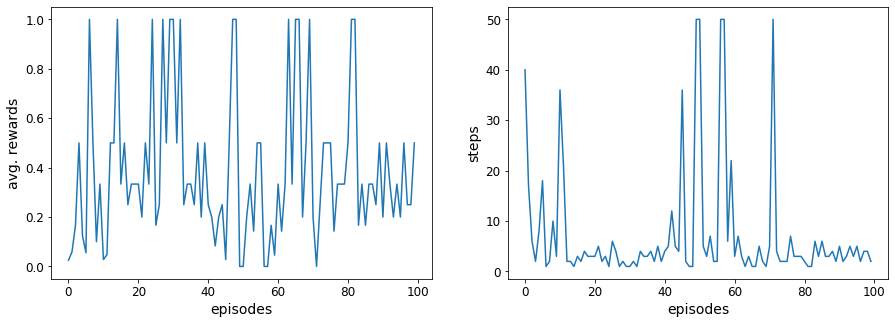

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(1,2, 1)
# TODO (1): plot average rewards
plt.plot(results['rewards'])
plt.xlabel('episodes')
plt.ylabel('avg. rewards')

plt.subplot(1,2, 2)
# TODO (2): plot the number of steps
plt.plot(results['steps'])
plt.xlabel('episodes')
plt.ylabel('steps')

In [20]:
Q

array([[0.   , 0.   , 0.961],
       [0.   , 0.   , 0.97 ],
       [0.   , 0.   , 0.98 ],
       [0.   , 0.   , 0.99 ],
       [0.   , 0.   , 1.   ],
       [0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.98 ],
       [0.99 , 0.   , 0.   ],
       [0.98 , 0.   , 0.703],
       [0.97 , 0.961, 0.426],
       [0.961, 0.   , 0.   ]])

By taking the argmax of `Q` and indexing our human readable environment's actions variable `s_Actions` we can get the actions our policy would take in each state after training. Below is the code for visualizing our policy in a human readable format.

Note, notice that in state five (our goal state) all the values are 0 and the action  picked defaults to left. Unlike last week, where we had to remain in the goal state to complete the task, this week we simply have to reach the goal state. That means once our next state variable `s1` is the goal state, then we are done with the episode. Thus, the Q-values of the goal state are always set to zero!

In [21]:
opt_policy_idx = np.argmax(Q, axis=1)
opt_policy = np.array(s_Actions)[opt_policy_idx]

columns = [ "state {}".format(s) for s in np.arange(0, 11)]
df = pd.DataFrame(opt_policy.reshape(1, -1), columns=columns)
df.index = ['aciton']
df

,state 0,state 1,state 2,state 3,state 4,state 5,state 6,state 7,state 8,state 9,state 10
aciton,RIGHT,RIGHT,RIGHT,RIGHT,RIGHT,LEFT,LEFT,LEFT,LEFT,LEFT,LEFT


# Q-Learning
Now, let's implement our second temporal difference algorithm Q-learning.

## Algorithm Summary
Below is the Q-learning algorithm. Let's quickly break it down to give you an idea of how it relates to TD and SARSA. 
 
$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)).
$$

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/678cb558a9d59c33ef4810c9618baf34a9577686)

### Notation 

#### Important Notation
- **state-action evaluation** or **action-value** or **Q-value**
    -  $Q(s, a)$
    - The estimated value of a state given said state $s$ and an action $a$
    
#### Summary
Just like SARSA, Q-learning uses a state-action evaluation $Q(s, a)$. If you want to review the notation for state action-value estimation see the SARSA section.

### What is happening
Q-learning is an off-policy TD update. Meaning, it does not use the policy definition to select the action $a_{t+1}$ after transitioning to a new state $s_{t+1}$. Instead, we simply take the max Q-value of the next state $s_{t+1}$, which corresponds to the best estimated action. In more concrete terms, with Q-learning, we do not call our `epsilon_greedy()` function when selecting the next state action $a_{t+1}$. Instead, we use the`np.max()` function to get best Q-value and `np.argmax()` to get the best action. 

So, just like SARSA, we still need to wait one time step for our target, which is now $ R_{t+1} + \gamma \max_a Q(s_{t+1}, a)$. Notice, that a 'max' is being taken over all the next state Q-values. This means we are ignoring our policy definition for selecting the next state's Q-value and instead taking whichever Q-value is the highest. This is the unique part of Q-learning that differentiates it from SARSA and makes it off-policy. Now, we just need to compute the difference between our next state's value estimation (target) and our current state's Q-value $( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t))$. 


### Pseudo code

![](http://incompleteideas.net/book/ebook/pseudotmp9.png)



### TODO:

Finish implementing the Q-learning algorithm. Here, our goal state is located at state 5 and our starting state is randomized in each episode. Read the code and fill in the TODOs.

Note, the `tqdm` allows us to visualize our for loop iterations with a loading bar.

1. Initialize our environment variable `env` using the `.init()` method. Store the output into `s`.


2. Select our action $a$ by using the `epsilon_greedy()` function defined above.  Store the output into `a`.
    1. Hint: Remember, to pass the epsilon value and the Q-values for the current state (i.e index $Q$ at the given state $s$, this should be a vector).


3. Execute the current action using the `.next()` method by passing the current state `s` and action. The current action is determined by indexing `As` (the set of all actions) at `a` (the current action index). Store the next state and reward into `s1` and `r1`.


5. Update our current state action-value estimate $Q(s_{t}, a_{t})$ by using the Q-learning algorithm $Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t))$. Store the output into `Q[s, a]`.
    1. Hint: Now instead of simply indexing `Q[s1, a1]` to get the next state Q-value given by the policy, take the max Q-value by taking the `np.max()` over the next state's Q-values (use `:` to index all the Q-values for a given state)!


6. Set **all** the next state Q-values $Q(s_{t+1}, a)$ to zero, i.e `Q[s1, :]`, once we have reached the goal state.

In [10]:
import pandas as pd
from IPython.display import display, HTML
from tqdm import tqdm



# Define discounting factor
gamma = 0.99

# define larning rate
alpha = 1.0

# max number of iterations (episodes)
max_iter = 100

# max number of steps per episode
max_step = 50

# Define epsilon
epsilon = 0.1

# Reinitialize the environment
As = env.get_actions() # all the actions

# Get number of states and actions
n_s = env.get_n_states()
n_a = env.get_n_actions()

# Define state-action value (Q) table
Q = np.zeros((n_s, n_a))

# print option
verbose = False

s_Actions = ['LEFT', "NONE", "RIGHT"]


results = {'rewards': [], 'steps': []}

for i in tqdm(range(max_iter)):
    #print ("\nIteration #{}".format(i+1))

    # TODO (1)
    s = env.init()
    if verbose: 
        print("\tstarting at {}".format(s))
    
    rewards = []

    for step in range(max_step):
        
        # TODO (2)
        a = epsilon_greedy(epsilon, Q[s])
        
        # TODO (3)
        s1, r1 = env.next(s, As[a])
              
        if verbose: 
            print("\t\t {} -> {} -> {}, R: {}".format(s, s_Actions[a], s1, r1))
        
        rewards.append(r1)

        # TODO (4)
        Q[s, a] += alpha * (r1 + gamma * np.max(Q[s1, :]) - Q[s, a])

        if env.is_done(s1): # reached the goal
            # TODO (5)
            Q[s1, :] = 0
            break

        # Set next state and action to current state and action
        s,a  = s1, a1 


    results['rewards'].append(np.mean(rewards))
    results['steps'].append(step+1)            
      

100%|██████████| 100/100 [00:00<00:00, 4006.06it/s]


### TODO:

Now plot how much average reward we got and how many steps it took to complete each episode during the training.

1. Plot the average rewards using the matplotlib `plt.plot()` function and pass `results` indexed at 'rewards'. 

2. Plot the number of steps using the matplotlib `plt.plot()` function and pass `results` indexed at 'steps'. 

Text(0, 0.5, 'steps')

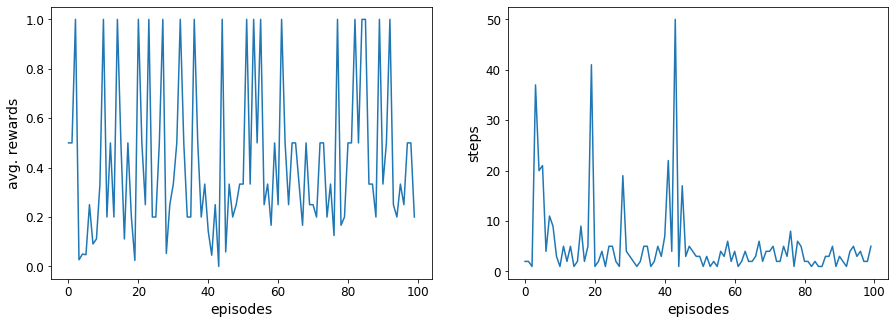

In [11]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
# TODO (1)
plt.plot(results['rewards'])
plt.xlabel('episodes')
plt.ylabel('avg. rewards')

plt.subplot(1, 2, 2)
# TODO (2)
plt.plot(results['steps'])
plt.xlabel('episodes')
plt.ylabel('steps')

In [12]:
Q

array([[0.   , 0.   , 0.961],
       [0.   , 0.961, 0.97 ],
       [0.961, 0.97 , 0.98 ],
       [0.97 , 0.   , 0.99 ],
       [0.98 , 0.99 , 1.   ],
       [0.   , 0.   , 0.   ],
       [1.98 , 0.99 , 0.98 ],
       [0.99 , 0.98 , 0.97 ],
       [0.98 , 0.   , 0.   ],
       [0.97 , 0.961, 0.951],
       [0.961, 0.   , 0.   ]])

In [20]:
opt_policy_idx = np.argmax(Q, axis=1)
opt_policy = np.array(s_Actions)[opt_policy_idx]

columns = [ "state {}".format(s) for s in np.arange(0, 11)]
df = pd.DataFrame(opt_policy.reshape(1, -1), columns=columns)
df.index = ['aciton']
df

,state 0,state 1,state 2,state 3,state 4,state 5,state 6,state 7,state 8,state 9,state 10
aciton,RIGHT,RIGHT,RIGHT,RIGHT,RIGHT,LEFT,LEFT,LEFT,LEFT,LEFT,LEFT


## Bonus TODOs:

Now you can play with different hyper-parameters (i.e., `gamma`, `alpha`, and `max_iter`). See how the learning changes as you change the aforementioned hyper-parameters. 